# **Preparation**

To get the "Chinses MNIST" dataset, please download the "archive.zip" from https://www.kaggle.com/gpreda/chinese-mnist .
Then use the following command to upload and unzip the package.

In [ ]:
from google.colab import files
uploaded = files.upload()
! unzip archive.zip

Saving archive.zip to archive (1).zip
Archive:  archive.zip
replace chinese_mnist.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Next we import all the libraries and functions we need.

In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm, metrics, datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.neighbors import KNeighborsClassifier

import keras
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import tensorflow_addons as tfa
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from skimage import exposure
import cv2

Then we define some global variables for image data import and Neural Network Construction

In [ ]:
IMAGE_PATH = './data/data/'
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 1
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
NO_EPOCHS = 50
DROPOUT_RATIO = 0.25
PATIENCE = 5
VERBOSE = 1

# **Data Exploration**

In [ ]:
# Have a glance at the root folder
os.listdir('./')

['.config', 'archive.zip', 'data', 'chinese_mnist.csv', 'sample_data']

In [ ]:
# read the data frames from the csv file
data_df=pd.read_csv('./chinese_mnist.csv')

In [ ]:
# show the total data sets' shape
data_df.shape

(15000, 5)

In [ ]:
# give a first glance at the data frame
data_df.sample(100).head()

,suite_id,sample_id,code,value,character
10033,11,3,5,4,四
12904,90,4,7,6,六
9226,29,6,4,3,三
7201,27,10,2,1,一
5770,79,1,15,100000000,亿


In [ ]:
# check whether the dataset lose any sample

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(data_df)

,Total,Percent
character,0,0.0
value,0,0.0
code,0,0.0
sample_id,0,0.0
suite_id,0,0.0


In [ ]:

image_files = list(os.listdir(IMAGE_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 15000


In [ ]:
def create_file_name(x):
    file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name

In [ ]:
data_df["file"] = data_df.apply(create_file_name, axis=1)
file_names = list(data_df['file'])
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))

Matching image names: 15000


In [ ]:
def read_image_sizes(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    return list(image.shape)

In [ ]:
m = np.stack(data_df['file'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h'])
data_df = pd.concat([data_df,df],axis=1, sort=False)
data_df.head()

,suite_id,sample_id,code,value,character,file,w,h
0,1,1,10,9,九,input_1_1_10.jpg,64,64
1,1,10,10,9,九,input_1_10_10.jpg,64,64
2,1,2,10,9,九,input_1_2_10.jpg,64,64
3,1,3,10,9,九,input_1_3_10.jpg,64,64
4,1,4,10,9,九,input_1_4_10.jpg,64,64


In [ ]:
print(f"Number of suites: {data_df.suite_id.nunique()}")
print(f"Samples: {data_df.sample_id.unique()}")

Number of suites: 100
Samples: [ 1 10  2  3  4  5  6  7  8  9]


Sepreating the dataset into training, testing and validation subsets

In [ ]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_df["code"].values)
train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=train_df["code"].values)
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))


Train set rows: 9600
Test  set rows: 3000
Val   set rows: 2400


In [ ]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT, 1), mode='reflect')
    return image[:,:,:]

In [ ]:
def categories_encoder(dataset, var='character'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [ ]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)
print(X_train.shape, X_val.shape, X_test.shape)

(9600, 64, 64, 1) (2400, 64, 64, 1) (3000, 64, 64, 1)


Reduce image blocksize by max-pooling and flaten the data into arrays

In [ ]:
def maxpool_image(image_set):
  image_mp = np.reshape(skimage.measure.block_reduce(image_set, block_size=(1,4,4,1), func=np.max), (image_set.shape[0], 16*16))
  return image_mp

In [ ]:
X_train_flat = np.reshape(X_train, (9600, 4096))
X_train_flat_mp = maxpool_image(X_train)
# X_train_flat_mp = np.reshape(skimage.measure.block_reduce(X_train, block_size=(1,4,4,1), func=np.max), (train_df.shape[0], 16*16))
# X_train_flat = np.array(X_train_flat)
print(X_train_flat.shape)
X_val_flat = np.reshape(X_val, (2400, 4096))
X_val_flat_mp = np.reshape(skimage.measure.block_reduce(X_val, block_size=(1,4,4,1), func=np.max), (val_df.shape[0], 16*16))
print(X_val_flat.shape)
X_test_flat = np.reshape(X_test, (3000, 4096))
X_test_flat_mp = np.reshape(skimage.measure.block_reduce(X_test, block_size=(1,4,4,1), func=np.max), (test_df.shape[0], 16*16))
print(X_test_flat.shape)

# print(X_train_flat.shape)
# print(np.arange(15).reshape((15,1)))
print(y_train)

y_train_flat = np.ravel(y_train @ (np.arange(15).reshape((15,1))) )
print(y_train_flat.shape)
y_val_flat = np.ravel(y_val @ (np.arange(15).reshape((15,1))) )
print(y_val_flat.shape)
y_test_flat = np.ravel(y_test @ (np.arange(15).reshape((15,1))) )
print(y_test_flat.shape)
# print(y_train_flat[3])

(9600, 4096)
(2400, 4096)
(3000, 4096)
       一  七  万  三  九  二  五  亿  八  六  十  千  四  百  零
7822   1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
4095   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
4585   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
131    0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
12667  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
...   .. .. .. .. .. .. .. .. .. .. .. .. .. .. ..
6822   0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
6631   0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
3122   0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
7584   1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
2382   0  0  0  0  0  0  0  0  0  0  0  0  0  1  0

[9600 rows x 15 columns]
(9600,)
(2400,)
(3000,)


Predicted digit :  10


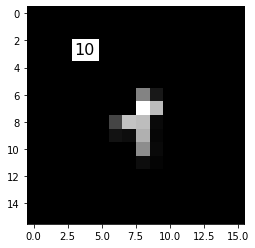

~~~
Predicted digit :  6


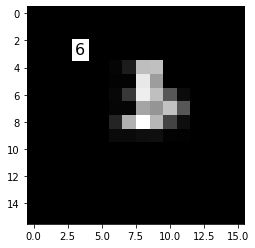

~~~
Predicted digit :  10


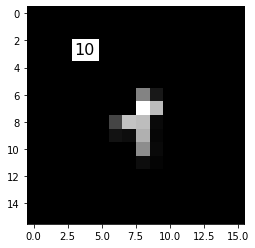

~~~
Predicted digit :  3


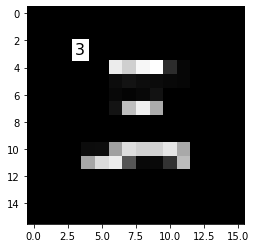

~~~
Predicted digit :  4


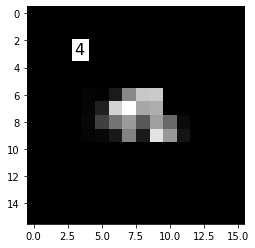

~~~


In [ ]:
for i in np.random.randint(0, 30, size=(5,)):
  # grab the image and classify it
  image = X_val_flat_mp[i]
  prediction = y_val_flat[i]
  
  # show the prediction
  imgdata = np.array(image, dtype='float')
  pixels = imgdata.reshape((16,16))
  plt.imshow(pixels,cmap='gray')
  plt.annotate(prediction,(3,3),bbox={'facecolor':'white'},fontsize=16)
  print("Predicted digit : ",prediction)
  plt.show()
  print("~~~")

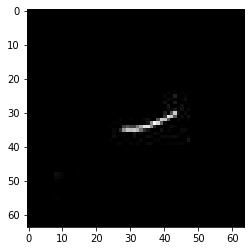

In [ ]:
image = X_train_flat[14]
# prediction = model.predict([image])[0]

# show the prediction
imgdata = np.array(image, dtype='float')
pixels = imgdata.reshape((64,64))
plt.imshow(pixels,cmap='gray')
# plt.annotate(prediction,(3,3),bbox={'facecolor':'white'},fontsize=16)
# print("Predicted digit : ",prediction)
plt.show()
# print(y_train_flat[5])

# **KNN**

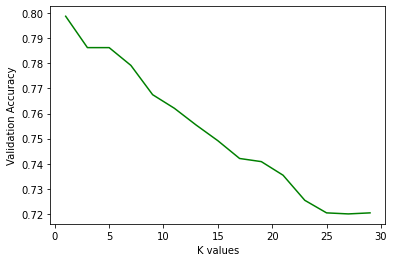

[0.79875, 0.78625, 0.78625, 0.7791666666666667, 0.7675, 0.7620833333333333, 0.7554166666666666, 0.7491666666666666, 0.7420833333333333, 0.7408333333333333, 0.7354166666666667, 0.7254166666666667, 0.7204166666666667, 0.72, 0.7204166666666667]


In [ ]:
k_values = range(1, 30, 2)
accuracies = []

# loop over various values of `k` for the k-Nearest Neighbor classifier

for k in range(1, 30, 2):
  model = KNeighborsClassifier(n_neighbors=k, p=2)
  model.fit(X_train_flat_mp, y_train_flat)
  score = model.score(X_val_flat_mp, y_val_flat)
  accuracies.append(score)

plt.plot(k_values, accuracies, color='g')
plt.xlabel("K values")
plt.ylabel("Validation Accuracy")
plt.show()
print(accuracies)

In [ ]:

model = KNeighborsClassifier(n_neighbors=5, p=1)
model.fit(X_train_flat_mp, y_train_flat)
predictions = model.predict(X_test_flat)
print("EVALUATION ON TESTING DATA")
print(classification_report(y_test_flat, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.65      0.99      0.79       200
           1       0.72      0.79      0.75       200
           2       0.68      0.80      0.73       200
           3       0.77      0.65      0.70       200
           4       0.78      0.64      0.70       200
           5       0.68      0.73      0.71       200
           6       0.89      0.71      0.79       200
           7       0.83      0.73      0.78       200
           8       0.91      0.95      0.93       200
           9       0.81      0.70      0.75       200
          10       0.64      0.82      0.72       200
          11       0.80      0.59      0.68       200
          12       0.84      0.87      0.86       200
          13       0.80      0.72      0.76       200
          14       0.98      0.90      0.94       200

    accuracy                           0.77      3000
   macro avg       0.79      0.77      0.77      3000

# **SVM**

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
# param_grid = [
#   {'C': [1], 'gamma': [0.001], 'kernel': ['rbf']}]
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(X_train_flat_mp, y_train_flat)
y_pred = clf.predict(X_test_flat_mp)
print("Classification report for - \n{}:\n{}\n".format(
    clf, metrics.classification_report(y_test_flat, y_pred)))

Classification report for - 
GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0):
              precision    recall  f1-score   support

           0       0.68      0.92      0.78       200
           1       0.55      0.58      0.56       200
           2   

# **CNN**

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS))
earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

In [ ]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')
    fig.show(renderer="colab")



In [ ]:
model0=Sequential()
model0.add(Dense(1024, activation='relu', input_shape=(4096,)))
model0.add(Dropout(DROPOUT_RATIO))
model0.add(Dense(256, activation='relu'))
model0.add(Dropout(DROPOUT_RATIO))
model0.add(Dense(64, activation='relu'))
model0.add(Flatten())
model0.add(Dense(15, activation='softmax'))
model0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model0.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                16448     
_________________________________________________________________
flatten_12 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 15)              

In [ ]:
cnn_model0 = model0.fit(X_train_flat, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val_flat, y_val)
                  ,
                  callbacks=[earlystopper, checkpointer, annealer])
plot_accuracy_and_loss(cnn_model0)


Epoch 1/50
293/300 [============================>.] - ETA: 0s - loss: 1.8991 - accuracy: 0.3970
Epoch 00001: val_accuracy did not improve from 0.96292
300/300 [==============================] - 1s 4ms/step - loss: 1.8841 - accuracy: 0.4005 - val_loss: 1.1891 - val_accuracy: 0.6292
Epoch 2/50
299/300 [============================>.] - ETA: 0s - loss: 0.8723 - accuracy: 0.7147
Epoch 00002: val_accuracy did not improve from 0.96292
300/300 [==============================] - 1s 4ms/step - loss: 0.8716 - accuracy: 0.7146 - val_loss: 0.7514 - val_accuracy: 0.7533
Epoch 3/50
296/300 [============================>.] - ETA: 0s - loss: 0.4943 - accuracy: 0.8338
Epoch 00003: val_accuracy did not improve from 0.96292
300/300 [==============================] - 1s 4ms/step - loss: 0.4936 - accuracy: 0.8340 - val_loss: 0.6038 - val_accuracy: 0.7996
Epoch 4/50
297/300 [============================>.] - ETA: 0s - loss: 0.3148 - accuracy: 0.8971
Epoch 00004: val_accuracy did not improve from 0.96292
300

In [ ]:
model1=Sequential()
model1.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model1.add(Dropout(DROPOUT_RATIO))
model1.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Dropout(DROPOUT_RATIO))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 64, 64, 16)        160       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 64, 64, 16)        2320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 15)                983055    
Total params: 985,535
Trainable params: 985,535
Non-trainable params: 0
________________________________________________

In [ ]:
cnn_model1 = model1.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val),
                  callbacks=[earlystopper, checkpointer, annealer])
plot_accuracy_and_loss(cnn_model1)

Epoch 1/50
299/300 [============================>.] - ETA: 0s - loss: 1.7295 - accuracy: 0.4747
Epoch 00001: val_accuracy improved from -inf to 0.61625, saving model to best_model.h5
300/300 [==============================] - 3s 9ms/step - loss: 1.7286 - accuracy: 0.4750 - val_loss: 1.2966 - val_accuracy: 0.6162
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.9326 - accuracy: 0.7121
Epoch 00002: val_accuracy improved from 0.61625 to 0.75167, saving model to best_model.h5
300/300 [==============================] - 2s 8ms/step - loss: 0.9326 - accuracy: 0.7121 - val_loss: 0.8161 - val_accuracy: 0.7517
Epoch 3/50
294/300 [============================>.] - ETA: 0s - loss: 0.6632 - accuracy: 0.7919
Epoch 00003: val_accuracy improved from 0.75167 to 0.76000, saving model to best_model.h5
300/300 [==============================] - 2s 8ms/step - loss: 0.6635 - accuracy: 0.7922 - val_loss: 0.7641 - val_accuracy: 0.7600
Epoch 4/50
294/300 [============================>.] 

In [ ]:
model2=Sequential()
model2.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model2.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model2.add(MaxPool2D(MAX_POOL_DIM))
model2.add(Dropout(DROPOUT_RATIO))
model2.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model2.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model2.add(Dropout(DROPOUT_RATIO))
model2.add(Flatten())
model2.add(Dense(y_train.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 32, 32, 16)        2320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 16)       

In [ ]:
cnn_model2 = model2.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val),
                  callbacks=[earlystopper, checkpointer, annealer])
plot_accuracy_and_loss(cnn_model2)

Epoch 1/50
294/300 [============================>.] - ETA: 0s - loss: 1.6326 - accuracy: 0.4966
Epoch 00001: val_accuracy did not improve from 0.86958
300/300 [==============================] - 2s 8ms/step - loss: 1.6179 - accuracy: 0.5015 - val_loss: 0.9303 - val_accuracy: 0.7175
Epoch 2/50
293/300 [============================>.] - ETA: 0s - loss: 0.7075 - accuracy: 0.7828
Epoch 00002: val_accuracy did not improve from 0.86958
300/300 [==============================] - 2s 7ms/step - loss: 0.7070 - accuracy: 0.7828 - val_loss: 0.5968 - val_accuracy: 0.8058
Epoch 3/50
295/300 [============================>.] - ETA: 0s - loss: 0.4762 - accuracy: 0.8498
Epoch 00003: val_accuracy did not improve from 0.86958
300/300 [==============================] - 2s 7ms/step - loss: 0.4754 - accuracy: 0.8499 - val_loss: 0.4716 - val_accuracy: 0.8554
Epoch 4/50
294/300 [============================>.] - ETA: 0s - loss: 0.3677 - accuracy: 0.8830
Epoch 00004: val_accuracy improved from 0.86958 to 0.87250

In [ ]:
model0_score = model0.evaluate(X_test_flat, y_test, verbose=0)
model1_score = model1.evaluate(X_test, y_test, verbose=0)
model2_score = model2.evaluate(X_test, y_test, verbose=0)
print("Model 0:")
print('Test loss:', model0_score[0])
print('Test accuracy:', model0_score[1])
print("Model 1:")
print('Test loss:', model1_score[0])
print('Test accuracy:', model1_score[1])
print("Model 2:")
print('Test loss:', model2_score[0])
print('Test accuracy:', model2_score[1])


Model 0:
Test loss: 0.9782489538192749
Test accuracy: 0.8603333234786987
Model 1:
Test loss: 0.9313163161277771
Test accuracy: 0.8669999837875366
Model 2:
Test loss: 0.31440114974975586
Test accuracy: 0.9573333263397217


In [ ]:
def test_accuracy_report(model,input):
    if input == 'flat':
      test = X_test_flat
    else:
      test = X_test
    predicted = model.predict(test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [ ]:
print("Model 0:")
test_accuracy_report(model0,'flat')
print("Model 1:")
test_accuracy_report(model1,'origin')
print("Model 2:")
test_accuracy_report(model2,'origin')

Model 0:
              precision    recall  f1-score   support

           一       0.96      0.96      0.96       200
           七       0.90      0.81      0.85       200
           万       0.80      0.78      0.79       200
           三       0.90      0.83      0.87       200
           九       0.66      0.84      0.74       200
           二       0.83      0.86      0.85       200
           五       0.86      0.93      0.89       200
           亿       0.86      0.77      0.81       200
           八       0.98      0.93      0.95       200
           六       0.92      0.76      0.83       200
           十       0.83      0.89      0.86       200
           千       0.83      0.77      0.80       200
           四       0.86      0.90      0.88       200
           百       0.76      0.83      0.80       200
           零       0.92      0.93      0.93       200

    accuracy                           0.85      3000
   macro avg       0.86      0.85      0.85      3000
weighted avg     

# **PCA**

In [ ]:
pca = PCA(256)  # project from 4096 to 256 dimensions
pca = pca.fit(X_train_flat)

X_train_pca = pca.transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)
X_val_pca = pca.transform(X_val_flat)
X_train_projected = pca.inverse_transform(X_train_pca)
X_test_projected = pca.inverse_transform(X_test_pca)
X_val_projected = pca.inverse_transform(X_val_pca)


The loss of training set:  0.000915099461698033
The loss of validation set:  0.0009787044433540529


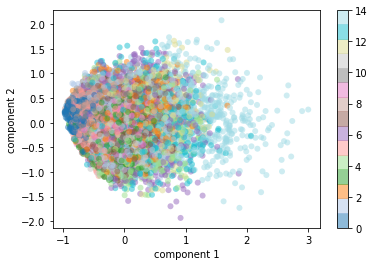

In [ ]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
            c=y_train_flat, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('tab20', 15))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
loss = ((X_train_flat - X_train_projected) ** 2).mean()
print("The loss of training set: ", loss)
val_loss = ((X_val_flat - X_val_projected) ** 2).mean()
print("The loss of validation set: ", val_loss)

76.89999999999947


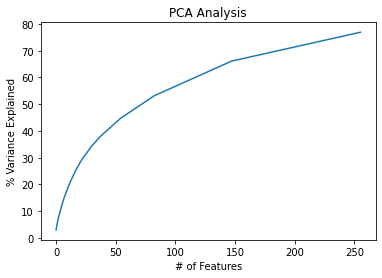

In [ ]:
variance = pca.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')
plt.plot(var)
print(var[-1])

In [ ]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    # for i, ax in enumerate(axes.flat):
    #     ax.imshow(data[i].reshape(16, 16),
    #               cmap='Greys', interpolation='nearest',
    #               clim=(0, 16))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(16, 16),
                  cmap='binary', interpolation='quadric',
                  clim=(0, 16))
        


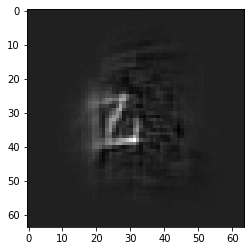

~~~


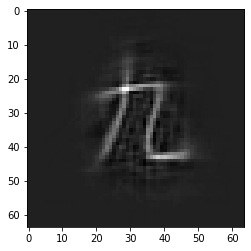

~~~


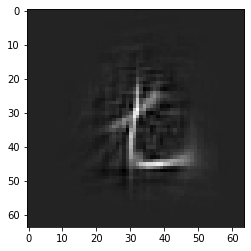

~~~


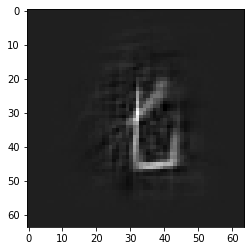

~~~


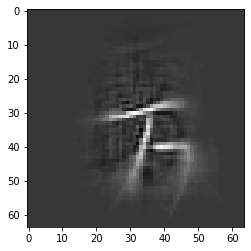

~~~


In [ ]:
for i in np.random.randint(0, 30, size=(5,)):
  # grab the image and classify it
  image = X_train_projected[i]
  imgdata = np.array(image, dtype='float')
  pixels = imgdata.reshape((64,64))
  plt.imshow(pixels,cmap='gray')
  plt.show()
  print("~~~")

# **AutoEncoder**

In [ ]:
input_img = keras.Input(shape=(4096,))

encoded = layers.Dense(1024, activation='relu')(input_img)
encoded = layers.Dense(256, activation='relu')(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)
# encoded = layers.Dense(2, activation='relu')(encoded)

# decoded = layers.Dense(2, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(1024, activation='sigmoid')(decoded)
decoded = layers.Dense(4096, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS))
earlystopper = EarlyStopping(monitor='binary_crossentropy', patience=PATIENCE, verbose=VERBOSE)
checkpointer = ModelCheckpoint('autoencoder.h5',
                                monitor='binary_crossentropy',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS))
earlystopper = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer = ModelCheckpoint('autoencoder.h5',
                                monitor='binary_crossentropy',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

autoencoder.fit(X_train_flat, X_train_flat,
                epochs=NO_EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(X_test_flat, X_test_flat),
                callbacks=[earlystopper, checkpointer, annealer])

Epoch 1/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0242 - val_loss: 0.0280
Epoch 2/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0243 - val_loss: 0.0280
Epoch 3/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0242 - val_loss: 0.0279
Epoch 4/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0241 - val_loss: 0.0279
Epoch 5/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0240 - val_loss: 0.0280
Epoch 6/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0239 - val_loss: 0.0280
Epoch 7/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0239 - val_loss: 0.0280
Epoch 8/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0238 - val_loss: 0.0280
Epoch 9/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0237 - val_loss: 0.0280
Epoch 00009: early stopping


In [ ]:
def plot_loss_and_val_loss(train_model):
    hist = train_model.history
    # acc = hist['accuracy']
    # val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    # trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    # trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=1, subplot_titles=('Training and validation loss',                                                            'Training and validation loss'))
    #add traces to the figure
    # fig.append_trace(trace_ta,1,1)
    # fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,1)
    fig.append_trace(trace_vl,1,1)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    # fig['layout']['xaxis2'].update(title = 'Epoch')
    # fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='autoencoder-loss')
    fig.show(renderer="colab")

In [ ]:
X_train_decoded = autoencoder.predict(X_train_flat)
X_train_encoded = encoder.predict(X_train_flat)
X_test_decoded = autoencoder.predict(X_test_flat)
X_test_encoded = encoder.predict(X_test_flat)
X_val_decoded = autoencoder.predict(X_val_flat)
X_val_encoded = encoder.predict(X_val_flat)
# X_train_encoded = np.reshape(X_train_encoded, (X_train.shape[0], 512))

# print(X_train_encoded[0])
# image1 = X_train_decoded[9]
# imgdata1 = np.array(image1, dtype='float')
# pixels1 = imgdata1.reshape((64,64))
# plt.imshow(pixels1,cmap='gray')
# plt.show()
# image2 = X_train_encoded[9]
# imgdata2 = np.array(image2, dtype='float')
# pixels2 = imgdata2.reshape((8,8))
# plt.imshow(pixels2,cmap='gray')
# plt.show()
# print(y_train_flat[5])


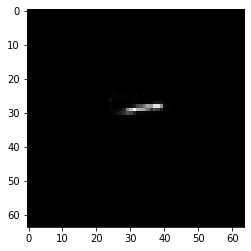

~~~


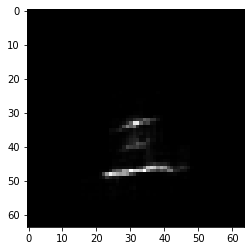

~~~


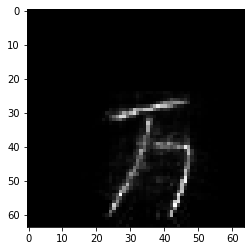

~~~


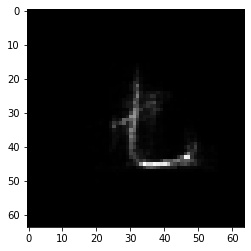

~~~


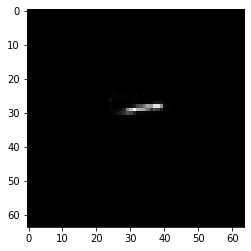

~~~


In [ ]:
for i in np.random.randint(0, 30, size=(5,)):
  # grab the image and classify it
  image = X_train_decoded[i]
  imgdata = np.array(image, dtype='float')
  pixels = imgdata.reshape((64,64))
  plt.imshow(pixels,cmap='gray')
  plt.show()
  print("~~~")

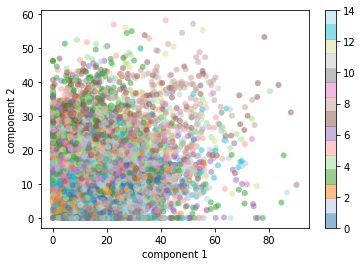

In [ ]:
plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1],
            c=y_train_flat, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('tab20', 15))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

# **K-means**

K-means with maxpooled training set

In [ ]:
# The number of clusters to form as well as the number of centroids to generate.
num_clusters = [15,30,60]

# Maximum number of iterations of the k-means algorithm for a single run.
max_iter = [10,50,100]

#Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive.
n_runs = 20

for n_clusters in num_clusters:
  print("The number of clusters is: ", n_clusters)
  for iter in max_iter:
    kmeans = KMeans(
        n_clusters=n_clusters, init='random',
        n_init=n_runs, max_iter=iter, 
        tol=1e-04, random_state=0
    )
    kmeans.fit(X_train_flat_mp)
    y_pred_km = kmeans.predict(X_train_flat_mp)
    print("The result for ",iter,"iters:  ")
    print("homogeneity_score", homogeneity_score(y_train_flat, y_pred_km)) # homogeneity: each cluster contains only members of a single class
    print("completeness_score", completeness_score(y_train_flat, y_pred_km)) # completeness: all members of a given class are assigned to the same cluster
    print("v_measure_score", v_measure_score(y_train_flat, y_pred_km))

The number of clusters is:  15
The result for  10 iters:  
homogeneity_score 0.21106864658258426
completeness_score 0.21439457725970573
v_measure_score 0.2127186121902057
The result for  50 iters:  
homogeneity_score 0.20936992349177883
completeness_score 0.2124747130788447
v_measure_score 0.21091089261156332
The result for  100 iters:  
homogeneity_score 0.20930853528893711
completeness_score 0.21241390397190799
v_measure_score 0.2108497863822012
The number of clusters is:  30
The result for  10 iters:  
homogeneity_score 0.314141500159357
completeness_score 0.25598138349475663
v_measure_score 0.2820948891176131
The result for  50 iters:  
homogeneity_score 0.3104508143361845
completeness_score 0.25296759791758583
v_measure_score 0.27877682044515917
The result for  100 iters:  
homogeneity_score 0.3138987125581964
completeness_score 0.2556244908625141
v_measure_score 0.2817802614472712
The number of clusters is:  60
The result for  10 iters:  
homogeneity_score 0.3733906134701907
comp

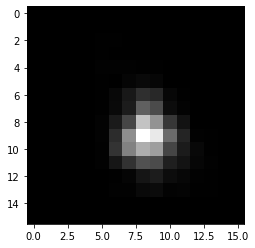

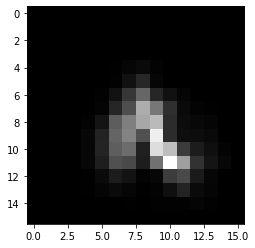

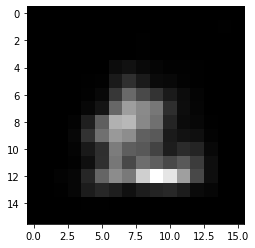

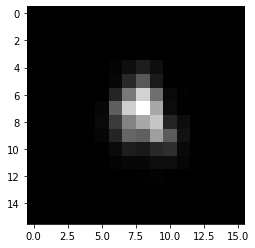

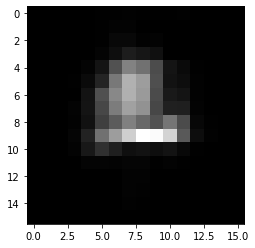

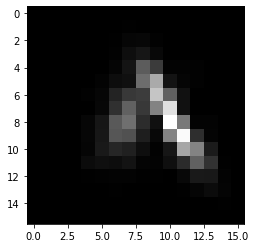

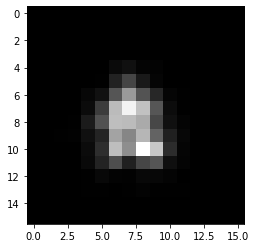

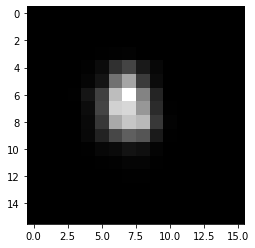

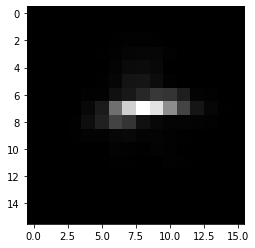

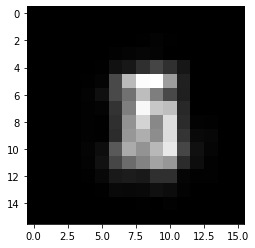

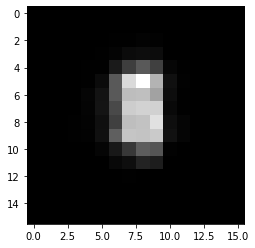

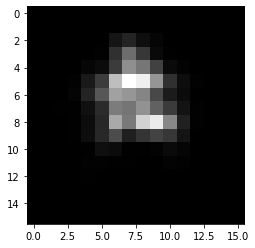

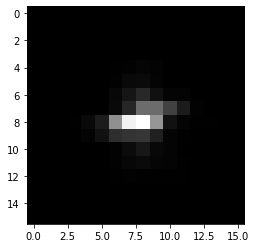

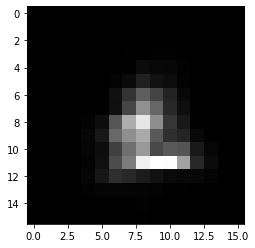

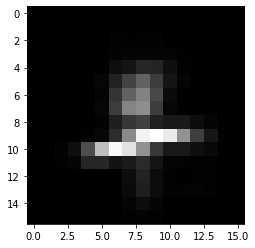

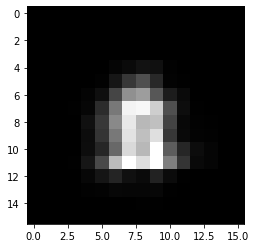

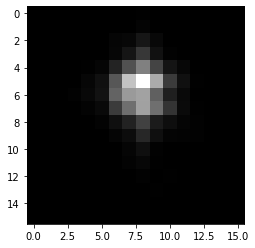

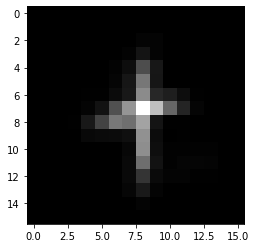

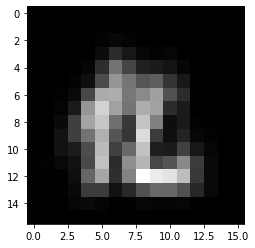

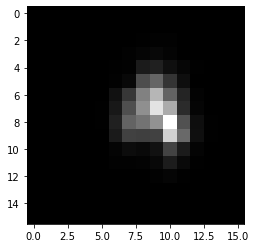

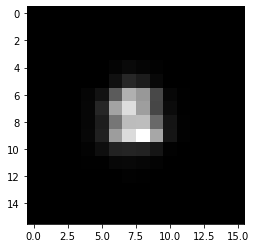

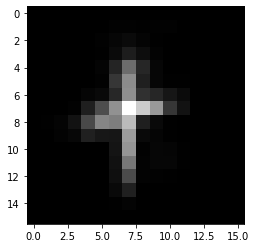

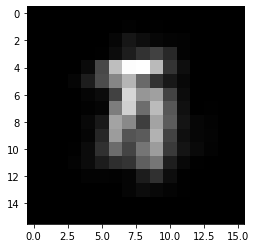

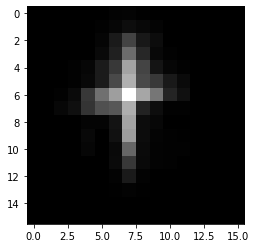

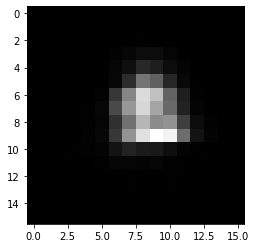

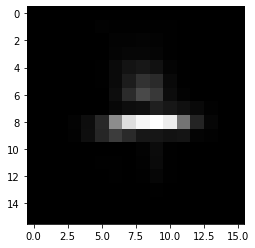

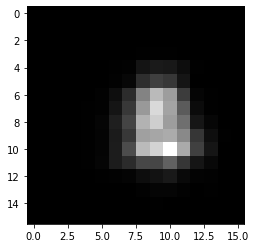

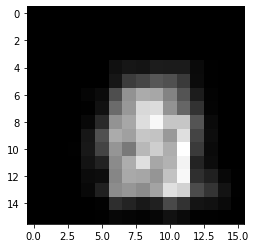

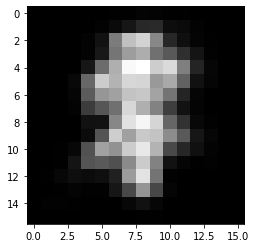

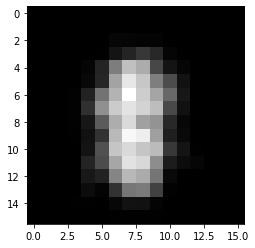

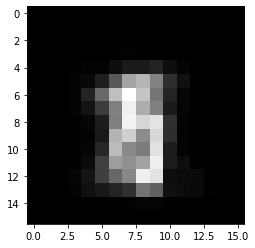

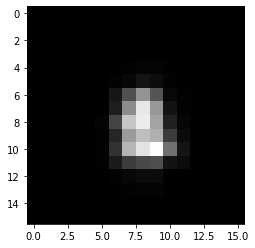

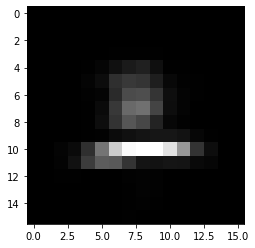

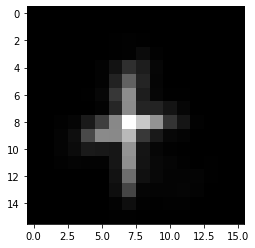

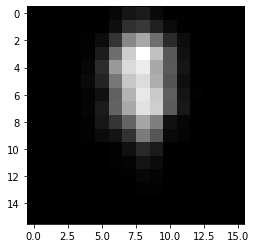

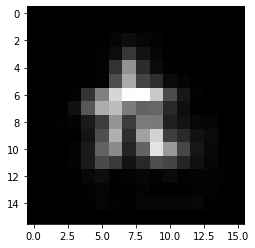

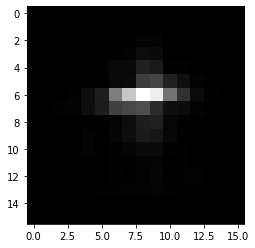

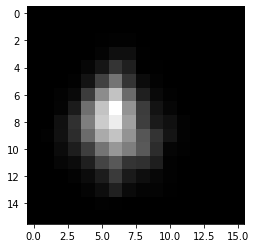

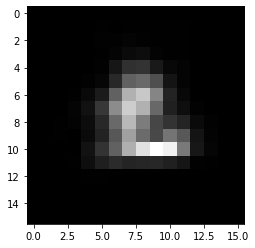

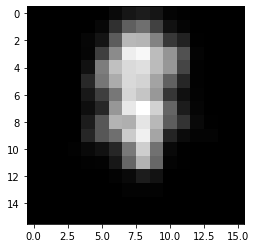

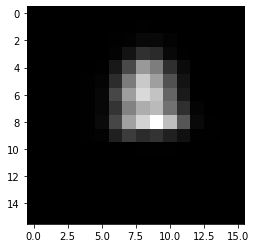

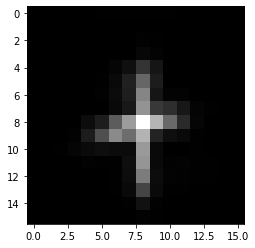

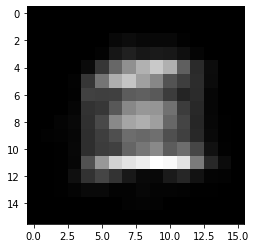

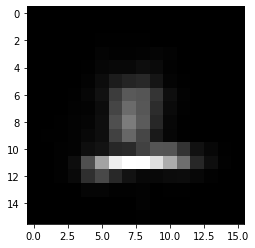

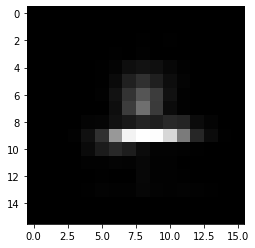

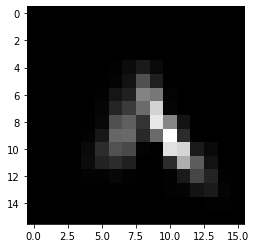

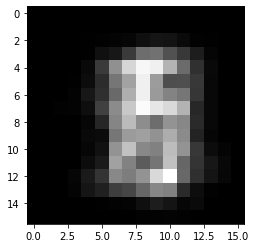

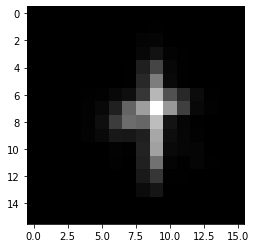

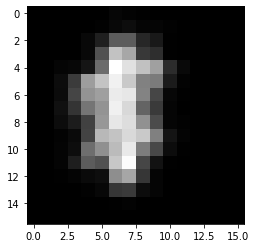

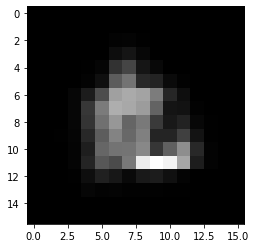

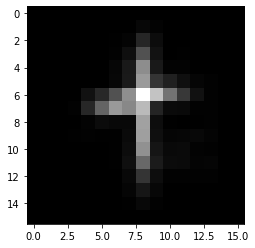

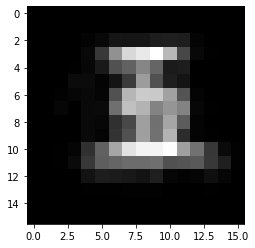

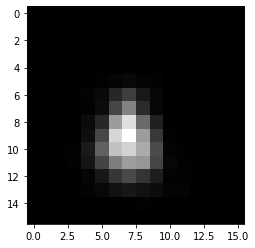

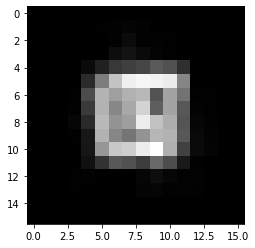

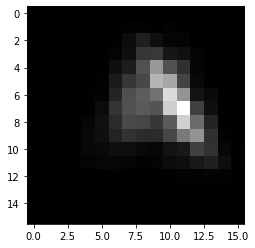

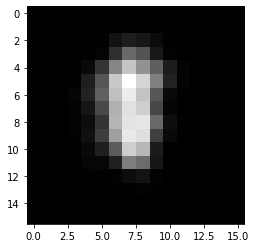

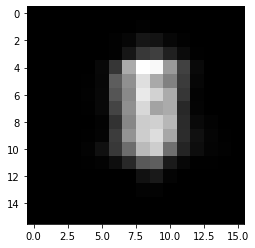

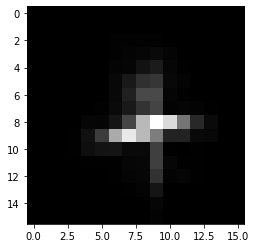

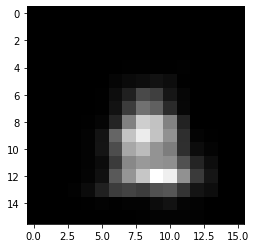

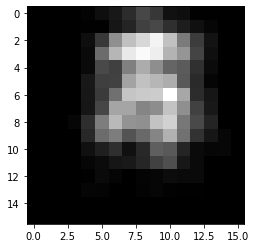

In [ ]:
for i in kmeans.cluster_centers_:
  image = i
  # prediction = y_val_flat[i]
  
  # show the prediction
  imgdata = np.array(image, dtype='float')
  pixels = imgdata.reshape((16,16))
  plt.imshow(pixels,cmap='gray')
  plt.show()

K-means with PCA training set

In [ ]:
# The number of clusters to form as well as the number of centroids to generate.
num_clusters = [15,30,60]

# Maximum number of iterations of the k-means algorithm for a single run.
max_iter = [10,50,100]

#Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive.
n_runs = 20

for n_clusters in num_clusters:
  print("The number of clusters is: ", n_clusters)
  for iter in max_iter:
    kmeans = KMeans(
        n_clusters=n_clusters, init='random',
        n_init=n_runs, max_iter=iter, 
        tol=1e-04, random_state=0
    )
    kmeans.fit(X_train_pca)
    y_pred_km = kmeans.predict(X_train_pca)
    print("The result for ",iter,"iters:  ")
    print("homogeneity_score", homogeneity_score(y_train_flat, y_pred_km)) # homogeneity: each cluster contains only members of a single class
    print("completeness_score", completeness_score(y_train_flat, y_pred_km)) # completeness: all members of a given class are assigned to the same cluster
    print("v_measure_score", v_measure_score(y_train_flat, y_pred_km))

The number of clusters is:  15
The result for  10 iters:  
homogeneity_score 0.17466194379347855
completeness_score 0.17960958295669446
v_measure_score 0.17710121482765745
The result for  50 iters:  
homogeneity_score 0.17481659065630728
completeness_score 0.1792431811473656
v_measure_score 0.177002214439366
The result for  100 iters:  
homogeneity_score 0.17384973499377368
completeness_score 0.17768100506142911
v_measure_score 0.17574449186723196
The number of clusters is:  30
The result for  10 iters:  
homogeneity_score 0.22506791894704012
completeness_score 0.18423630270005972
v_measure_score 0.20261545838122774
The result for  50 iters:  
homogeneity_score 0.22637580360939916
completeness_score 0.18471332981818525
v_measure_score 0.20343339229775848
The result for  100 iters:  
homogeneity_score 0.21555655160754456
completeness_score 0.17628755505522986
v_measure_score 0.19395436507985403
The number of clusters is:  60
The result for  10 iters:  
homogeneity_score 0.28876974050649

K-means with autoencoded training set

In [ ]:
# The number of clusters to form as well as the number of centroids to generate.
num_clusters = [15,30,60]

# Maximum number of iterations of the k-means algorithm for a single run.
max_iter = [10,50,100]

#Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive.
n_runs = 20

for n_clusters in num_clusters:
  print("The number of clusters is: ", n_clusters)
  for iter in max_iter:
    kmeans = KMeans(
        n_clusters=n_clusters, init='random',
        n_init=n_runs, max_iter=iter, 
        tol=1e-04, random_state=0
    )
    kmeans.fit(X_train_encoded)
    y_pred_km = kmeans.predict(X_train_encoded)
    print("The result for ",iter,"iters:  ")
    print("homogeneity_score", homogeneity_score(y_train_flat, y_pred_km)) # homogeneity: each cluster contains only members of a single class
    print("completeness_score", completeness_score(y_train_flat, y_pred_km)) # completeness: all members of a given class are assigned to the same cluster
    print("v_measure_score", v_measure_score(y_train_flat, y_pred_km))

The number of clusters is:  15
The result for  10 iters:  
homogeneity_score 0.18243464072558827
completeness_score 0.198759552677483
v_measure_score 0.19024753372963152
The result for  50 iters:  
homogeneity_score 0.18865749902145781
completeness_score 0.2031531028666767
v_measure_score 0.19563715795632655
The result for  100 iters:  
homogeneity_score 0.18517835522714274
completeness_score 0.20114051245544426
v_measure_score 0.19282966679560218
The number of clusters is:  30
The result for  10 iters:  
homogeneity_score 0.26714222803491444
completeness_score 0.22289545685210643
v_measure_score 0.24302126468522522
The result for  50 iters:  
homogeneity_score 0.2681794235765912
completeness_score 0.22786067228497237
v_measure_score 0.24638146899404084
The result for  100 iters:  
homogeneity_score 0.27025024701956213
completeness_score 0.2299600316798156
v_measure_score 0.24848252030201157
The number of clusters is:  60
The result for  10 iters:  
homogeneity_score 0.3625445773329116

# **GMM**

GMM with maxpooled training set

In [ ]:
# The number of clusters to form as well as the number of centroids to generate.
num_clusters = [15,30,60]

# Maximum number of iterations of the k-means algorithm for a single run.
max_iter = [10,50,100]

#Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive.
n_runs = 10

for n_clusters in num_clusters:
  print("The number of clusters is: ", n_clusters)
  for iter in max_iter:
    GMM = GaussianMixture(
        n_components=n_clusters,
        n_init=n_runs, max_iter=iter, 
        tol=1e-04, random_state=0
    )

    y_pred_gmm = GMM.fit_predict(X_train_flat_mp)
    print("The result for ",iter,"iters:  ")
    print("homogeneity_score", homogeneity_score(y_train_flat, y_pred_gmm)) # homogeneity: each cluster contains only members of a single class
    print("completeness_score", completeness_score(y_train_flat, y_pred_gmm)) # completeness: all members of a given class are assigned to the same cluster
    print("v_measure_score", v_measure_score(y_train_flat, y_pred_gmm))

The number of clusters is:  15


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



The result for  10 iters:  
homogeneity_score 0.12192336527052515
completeness_score 0.14978966595345378
v_measure_score 0.13442756185468646
The result for  50 iters:  
homogeneity_score 0.11707807441811746
completeness_score 0.14619077842645953
v_measure_score 0.1300247610070301
The result for  100 iters:  
homogeneity_score 0.11707807441811746
completeness_score 0.14619077842645953
v_measure_score 0.1300247610070301
The number of clusters is:  30


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



The result for  10 iters:  
homogeneity_score 0.18922161517538325
completeness_score 0.18127639215901753
v_measure_score 0.1851638121580288
The result for  50 iters:  
homogeneity_score 0.1868640300518109
completeness_score 0.17982405951231709
v_measure_score 0.18327646529610922
The result for  100 iters:  
homogeneity_score 0.1868640300518109
completeness_score 0.17982405951231709
v_measure_score 0.18327646529610922
The number of clusters is:  60


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



The result for  10 iters:  
homogeneity_score 0.29022752180292694
completeness_score 0.21594998590506032
v_measure_score 0.24763893412174098
The result for  50 iters:  
homogeneity_score 0.28556998426374286
completeness_score 0.2135933106776624
v_measure_score 0.2443923220605427
The result for  100 iters:  
homogeneity_score 0.28556998426374286
completeness_score 0.2135933106776624
v_measure_score 0.2443923220605427


GMM with PCA training set

In [ ]:
# The number of clusters to form as well as the number of centroids to generate.
num_clusters = [15,30,60]

# Maximum number of iterations of the k-means algorithm for a single run.
max_iter = [10,50,100]

#Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive.
n_runs = 10

for n_clusters in num_clusters:
  print("The number of clusters is: ", n_clusters)
  for iter in max_iter:
    GMM = GaussianMixture(
        n_components=n_clusters,
        n_init=n_runs, max_iter=iter, 
        tol=1e-04, random_state=0
    )

    y_pred_gmm = GMM.fit_predict(X_train_pca)
    print("The result for ",iter,"iters:  ")
    print("homogeneity_score", homogeneity_score(y_train_flat, y_pred_gmm)) # homogeneity: each cluster contains only members of a single class
    print("completeness_score", completeness_score(y_train_flat, y_pred_gmm)) # completeness: all members of a given class are assigned to the same cluster
    print("v_measure_score", v_measure_score(y_train_flat, y_pred_gmm))

GMM with autoencoded training set

In [ ]:
# The number of clusters to form as well as the number of centroids to generate.
num_clusters = [15,30,60]

# Maximum number of iterations of the k-means algorithm for a single run.
max_iter = [10,50,100]

#Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive.
n_runs = 10

for n_clusters in num_clusters:
  print("The number of clusters is: ", n_clusters)
  for iter in max_iter:
    GMM = GaussianMixture(
        n_components=n_clusters,
        n_init=n_runs, max_iter=iter, 
        tol=1e-04, random_state=0
    )

    y_pred_gmm = GMM.fit_predict(X_train_encoded)
    print("The result for ",iter,"iters:  ")
    print("homogeneity_score", homogeneity_score(y_train_flat, y_pred_gmm)) # homogeneity: each cluster contains only members of a single class
    print("completeness_score", completeness_score(y_train_flat, y_pred_gmm)) # completeness: all members of a given class are assigned to the same cluster
    print("v_measure_score", v_measure_score(y_train_flat, y_pred_gmm))